In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [2]:
!unzip "/content/archive.zip" -d "/content/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/sad/Training_65242339.jpg  
  inflating: /content/data/train/sad/Training_65267116.jpg  
  inflating: /content/data/train/sad/Training_65275626.jpg  
  inflating: /content/data/train/sad/Training_6529266.jpg  
  inflating: /content/data/train/sad/Training_65329617.jpg  
  inflating: /content/data/train/sad/Training_65338712.jpg  
  inflating: /content/data/train/sad/Training_65338797.jpg  
  inflating: /content/data/train/sad/Training_65387162.jpg  
  inflating: /content/data/train/sad/Training_65404494.jpg  
  inflating: /content/data/train/sad/Training_65426218.jpg  
  inflating: /content/data/train/sad/Training_65430136.jpg  
  inflating: /content/data/train/sad/Training_65437377.jpg  
  inflating: /content/data/train/sad/Training_6545735.jpg  
  inflating: /content/data/train/sad/Training_65463385.jpg  
  inflating: /content/data/train/sad/Training_65473985.jpg  
  inflating: /content/data/train/sad

In [3]:
train_dir = '/content/data/train/'
test_dir = '/content/data/test/'
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       disgust  neutral  fear  angry  surprise   sad  happy
train      436     4965  4097   3995      3171  4830   7215
      disgust  neutral  fear  angry  surprise   sad  happy
test      111     1233  1024    958       831  1247   1774


In [38]:
class_weight = {0: 28709/(436 * 7),
                1: 28709/(4965 * 7),
                2: 28709/(4097 * 7),
                3: 28709/(3995 * 7),
                4: 28709/(3171 * 7),
                5: 28709/(4830 * 7),
                6: 28709/(7215 * 7)}

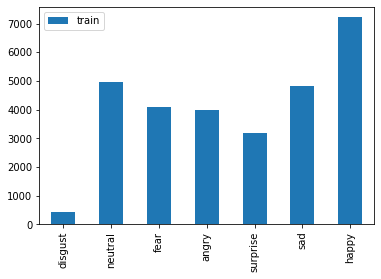

In [4]:
train_count.transpose().plot(kind='bar')

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [74]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
fernet = get_model((48,48,1), classes)
fernet.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156 (Conv2D)         (None, 48, 48, 64)        640       
                                                                 
 conv2d_157 (Conv2D)         (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_65 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_97 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_158 (Conv2D)         (None, 24, 24, 128)     

In [76]:
import datetime
chk_path = '/content/ferNet.h5'
log_dir = "/content/checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=6, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.7, 
                              patience=5, 
                              verbose=1, 
                              min_delta=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('/content/training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [77]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=100,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)
                # class_weight=class_weight)

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 1.9502 - accuracy: 0.2364
Epoch 1: val_loss improved from inf to 1.81095, saving model to /content/ferNet.h5
448/448 [==============================] - 31s 66ms/step - loss: 1.9502 - accuracy: 0.2364 - val_loss: 1.8110 - val_accuracy: 0.2472 - lr: 0.0010
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.8202 - accuracy: 0.2505
Epoch 2: val_loss did not improve from 1.81095
448/448 [==============================] - 28s 63ms/step - loss: 1.8202 - accuracy: 0.2505 - val_loss: 1.8269 - val_accuracy: 0.2472 - lr: 0.0010
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.8052 - accuracy: 0.2506
Epoch 3: val_loss did not improve from 1.81095
448/448 [==============================] - 28s 63ms/step - loss: 1.8052 - accuracy: 0.2506 - val_loss: 1.8527 - val_accuracy: 0.2473 - lr: 0.0010
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 1.7943 - accuracy: 0.25

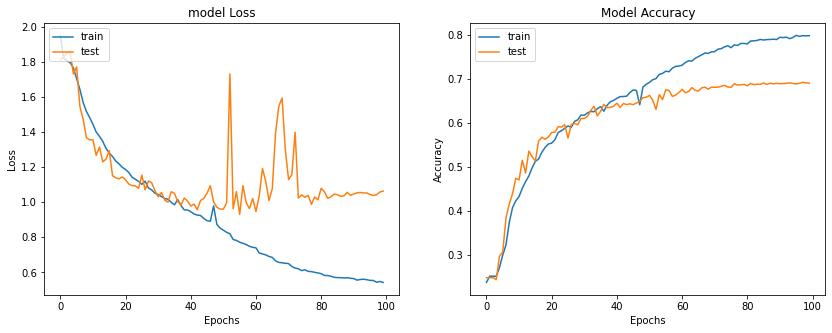

In [78]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 24ms/step - loss: 1.0616 - accuracy: 0.6909
final train accuracy = 83.91 , validation accuracy = 69.09
